*Importing Neccesary Libraries*

In [1]:
import pandas as pd
import numpy as np
import shap
import lime
import lime.lime_tabular
import tensorflow as tf
import collections
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

e:\codebook\Machine Learning\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


*Loading Dataset*

In [2]:
df=pd.read_csv('kdd_train.csv')
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune


*Data Preprocessing*

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [4]:
df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'labels'],
      dtype='object')

In [5]:
df.shape

(125973, 42)

In [ ]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


*Checking Unique Values*

In [7]:
df.nunique()

duration                       2981
protocol_type                     3
service                          70
flag                             11
src_bytes                      3341
dst_bytes                      9326
land                              2
wrong_fragment                    3
urgent                            4
hot                              28
num_failed_logins                 6
logged_in                         2
num_compromised                  88
root_shell                        2
su_attempted                      3
num_root                         82
num_file_creations               35
num_shells                        3
num_access_files                 10
num_outbound_cmds                 1
is_host_login                     2
is_guest_login                    2
count                           512
srv_count                       509
serror_rate                      89
srv_serror_rate                  86
rerror_rate                      82
srv_rerror_rate             

*Checking Duplicate Values*

In [8]:
df.duplicated().sum()

0

*Checking Missing Values*

In [9]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

**EDA**

*Distribution of Labels*

C:\Users\shrut\AppData\Local\Temp\ipykernel_9064\2138619718.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='labels', order=df['labels'].value_counts().index, palette="viridis")


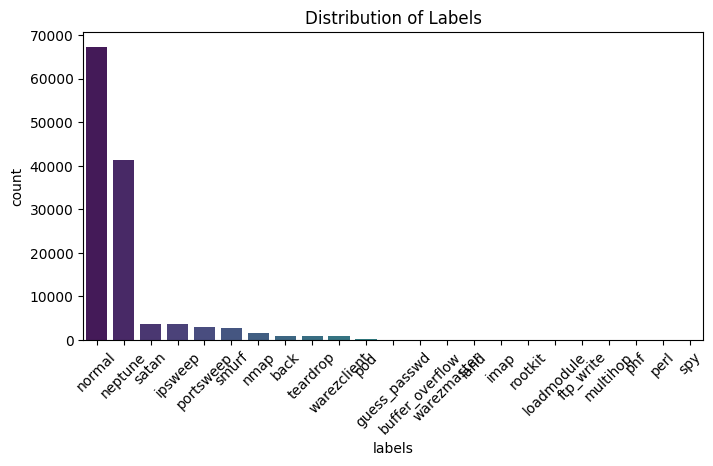

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.countplot(data=df, x='labels', order=df['labels'].value_counts().index, palette="viridis")
plt.title("Distribution of Labels")
plt.xticks(rotation=45)
plt.show()



*Protocol Distribution*

C:\Users\shrut\AppData\Local\Temp\ipykernel_9064\536123912.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='protocol_type', order=df['protocol_type'].value_counts().index, ax=axes[0], palette="Set2")
C:\Users\shrut\AppData\Local\Temp\ipykernel_9064\536123912.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df[df['service'].isin(top_services)], x='service', order=top_services, ax=axes[1], palette="Set3")
C:\Users\shrut\AppData\Local\Temp\ipykernel_9064\536123912.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot

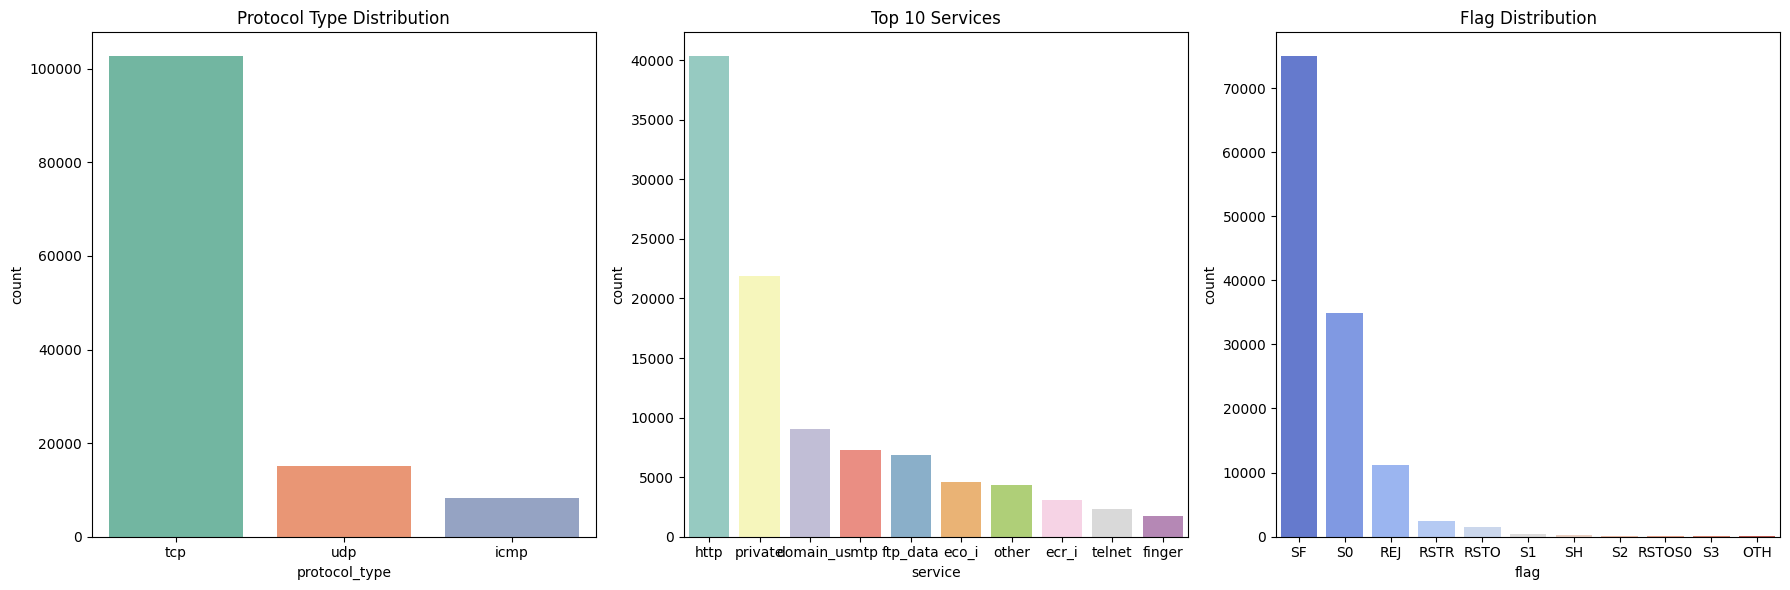

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))

sns.countplot(data=df, x='protocol_type', order=df['protocol_type'].value_counts().index, ax=axes[0], palette="Set2")
axes[0].set_title("Protocol Type Distribution")

top_services = df['service'].value_counts().head(10).index
sns.countplot(data=df[df['service'].isin(top_services)], x='service', order=top_services, ax=axes[1], palette="Set3")
axes[1].set_title("Top 10 Services")

sns.countplot(data=df, x='flag', order=df['flag'].value_counts().index, ax=axes[2], palette="coolwarm")
axes[2].set_title("Flag Distribution")

plt.tight_layout()
plt.show()


*Distribution by Label*

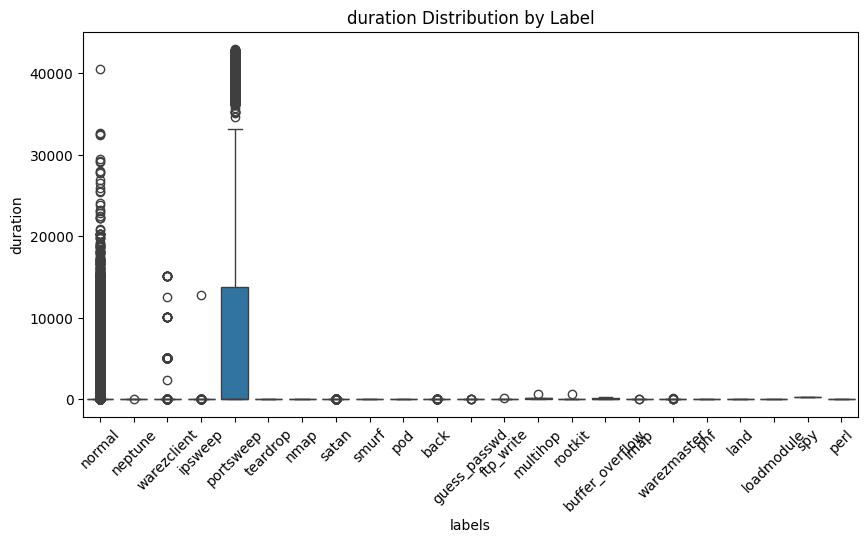

In [17]:
num_features = ['duration']
for col in num_features:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df, x='labels', y=col)
    plt.title(f"{col} Distribution by Label")
    plt.xticks(rotation=45)
    plt.show()


*Attack Category Distribution*

C:\Users\shrut\AppData\Local\Temp\ipykernel_9064\3304081687.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='attack_category', order=df['attack_category'].value_counts().index, palette="mako")


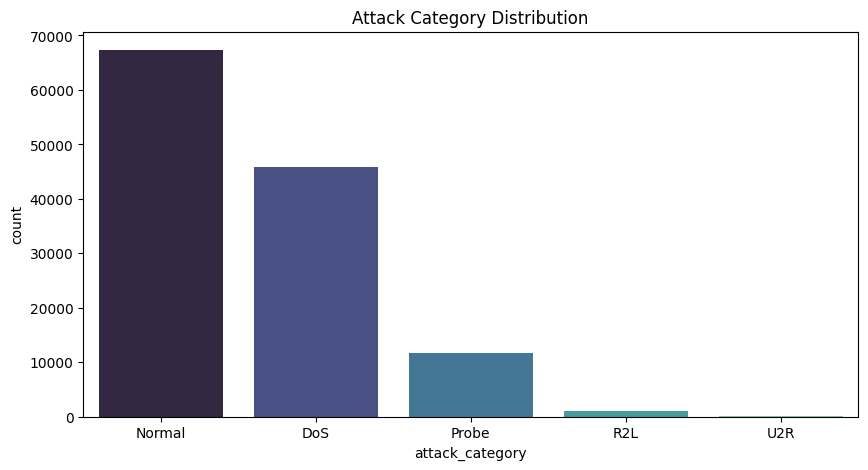

In [18]:
def categorize_attack(x):
    if x in ['back','land','neptune','pod','smurf','teardrop']:
        return 'DoS'
    elif x in ['satan','ipsweep','nmap','portsweep']:
        return 'Probe'
    elif x in ['guess_passwd','ftp_write','imap','phf','multihop','warezmaster','warezclient','spy']:
        return 'R2L'
    elif x in ['buffer_overflow','loadmodule','rootkit','perl']:
        return 'U2R'
    else:
        return 'Normal'

df['attack_category'] = df['labels'].apply(categorize_attack)

plt.figure(figsize=(10,5))
sns.countplot(data=df, x='attack_category', order=df['attack_category'].value_counts().index, palette="mako")
plt.title("Attack Category Distribution")
plt.show()


*Correlation Heatmap of Numeric Features*

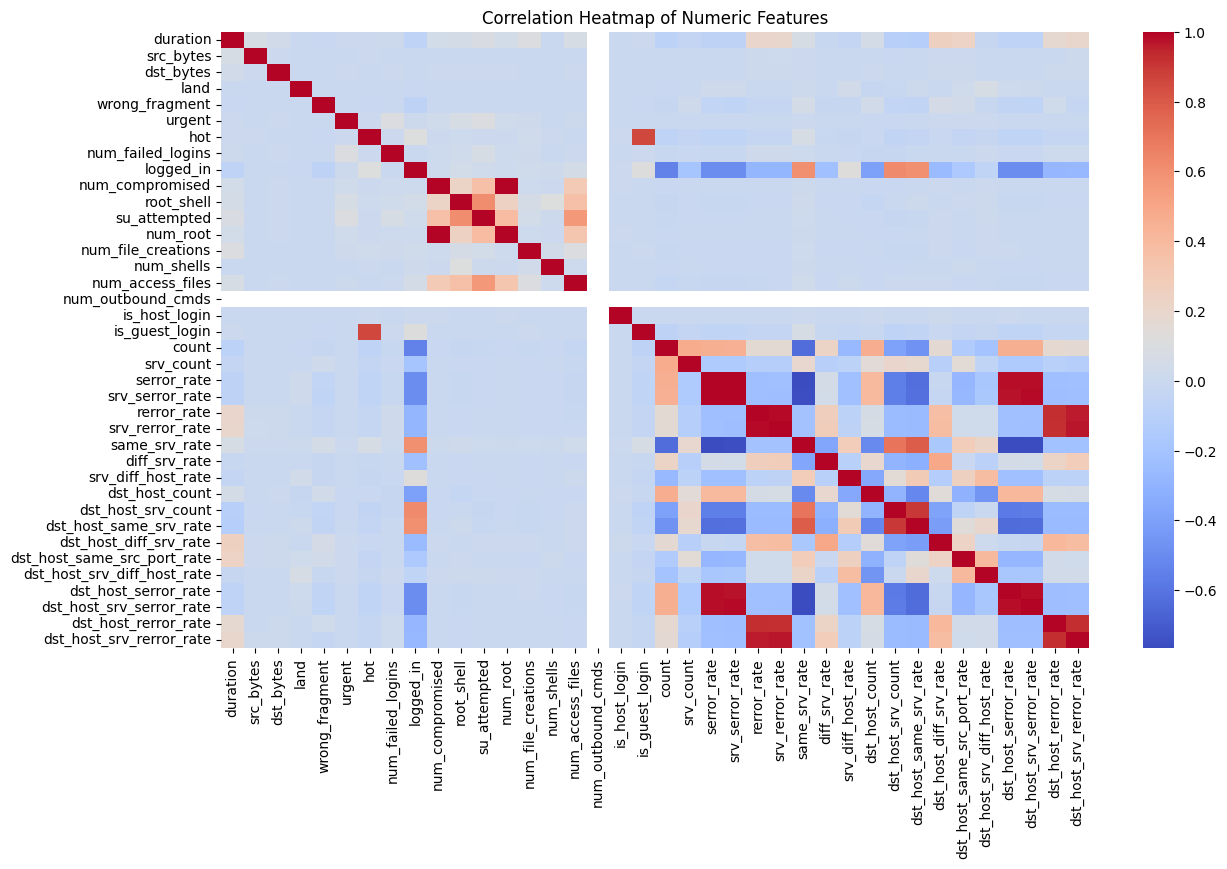

In [19]:
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


*Protocol Type by Attack Category*

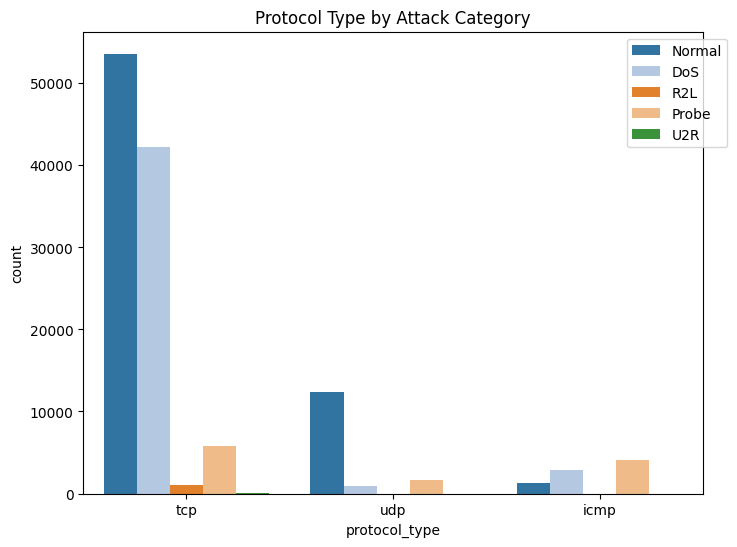

In [21]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='protocol_type', hue='attack_category', palette="tab20")
plt.title("Protocol Type by Attack Category")
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()


*Top 10 Services by Attack Category*

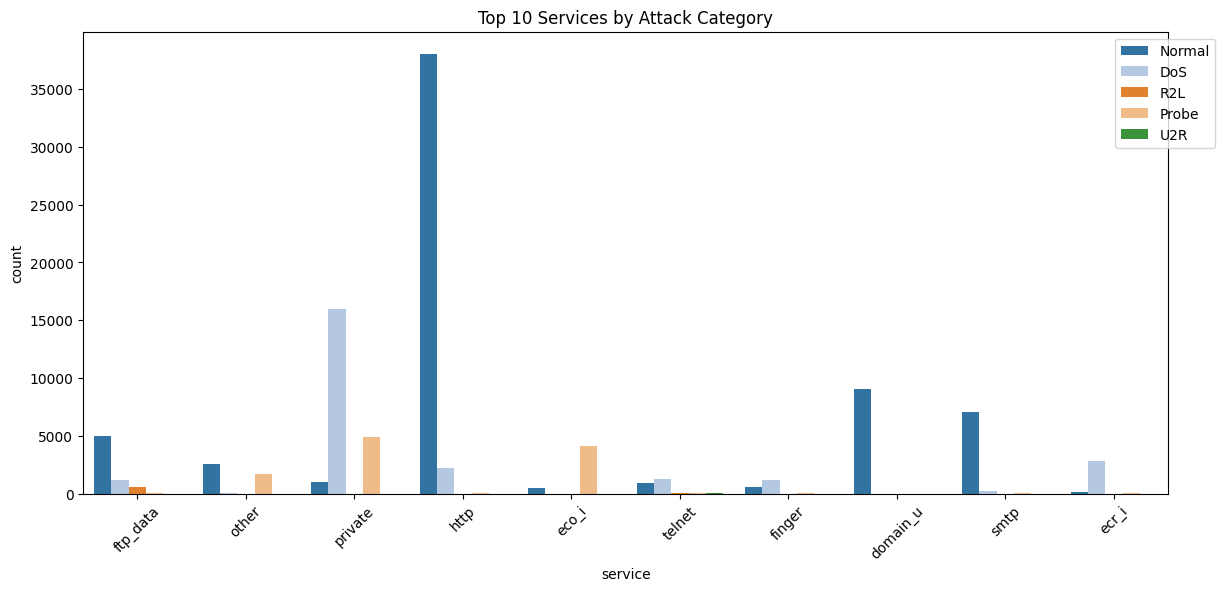

In [22]:
top_services = df['service'].value_counts().head(10).index
plt.figure(figsize=(14,6))
sns.countplot(data=df[df['service'].isin(top_services)], x='service', hue='attack_category', palette="tab20")
plt.title("Top 10 Services by Attack Category")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()


*Keeping Necessary Columns*

In [36]:
# Columns you want to KEEP
keep_columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'dst_host_same_srv_rate', 'dst_host_serror_rate',
    'attack_category'
]

# Drop everything else
df = df[keep_columns]


*Value Counts*

In [23]:
df['protocol_type'].value_counts()

protocol_type
tcp     102689
udp      14993
icmp      8291
Name: count, dtype: int64

In [24]:
df['service'].value_counts()

service
http         40338
private      21853
domain_u      9043
smtp          7313
ftp_data      6860
             ...  
tftp_u           3
http_8001        2
aol              2
harvest          2
http_2784        1
Name: count, Length: 70, dtype: int64

In [25]:
df['flag'].value_counts()

flag
SF        74945
S0        34851
REJ       11233
RSTR       2421
RSTO       1562
S1          365
SH          271
S2          127
RSTOS0      103
S3           49
OTH          46
Name: count, dtype: int64

In [26]:
df['labels'].value_counts()

labels
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

In [27]:
df['attack_category'].value_counts()

attack_category
Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64

*Label Encoding*

In [29]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
cols_to_encode = ['protocol_type','service','flag','labels','attack_category']

for col in cols_to_encode:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

In [30]:
df['protocol_type'].value_counts()

protocol_type
1    102689
2     14993
0      8291
Name: count, dtype: int64

In [31]:
df['service'].value_counts()

service
17    40338
44    21853
4      9043
50     7313
13     6860
      ...  
58        3
20        2
23        2
15        2
18        1
Name: count, Length: 70, dtype: int64

In [32]:
df['flag'].value_counts()

flag
10    74945
6     34851
1     11233
5      2421
3      1562
7       365
2       271
8       127
4       103
9        49
0        46
Name: count, dtype: int64

In [33]:
df['labels'].value_counts()

labels
11    67343
9     41214
17     3633
5      3599
15     2931
18     2646
10     1493
0       956
20      892
21      890
14      201
3        53
1        30
22       20
6        18
4        11
16       10
7         9
2         8
8         7
13        4
12        3
19        2
Name: count, dtype: int64

In [34]:
df['attack_category'].value_counts()

attack_category
1    67343
0    45927
2    11656
3      995
4       52
Name: count, dtype: int64

*Target class Distribution*

C:\Users\shrut\AppData\Local\Temp\ipykernel_9064\3078329642.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="Blues_d")


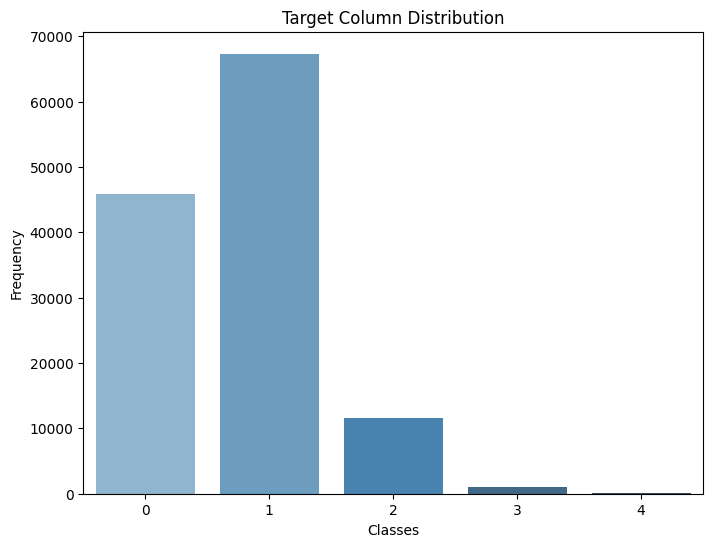

attack_category
1    67343
0    45927
2    11656
3      995
4       52
Name: count, dtype: int64


In [37]:
# Count the occurrences of each class
class_counts = df['attack_category'].value_counts()

# Plotting the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Blues_d")
plt.title('Target Column Distribution')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

# Print the class distribution
print(class_counts)

*Balancing Data*

In [38]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Separate features and target
X = df.drop('attack_category', axis=1)
y = df['attack_category']  # already int type (0 = ham, 1 = spam)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check new class distribution
print(pd.Series(y_resampled).value_counts())


attack_category
1    67343
0    67343
3    67343
2    67343
4    67343
Name: count, dtype: int64


*Data Correlation*

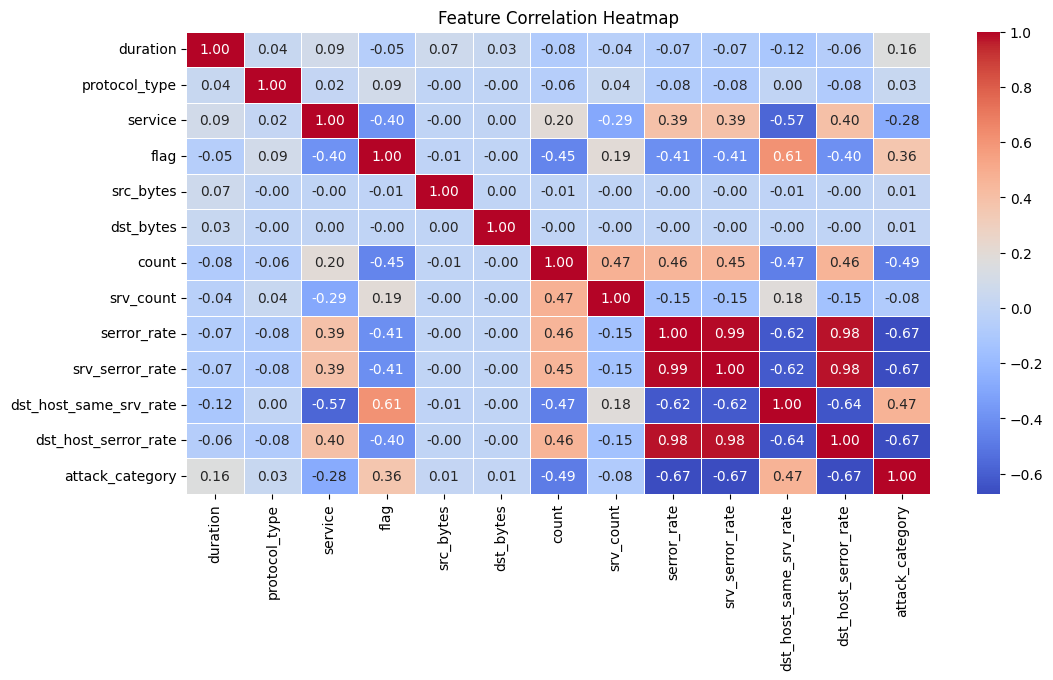

Strong Correlations:
 srv_serror_rate         serror_rate               0.993289
serror_rate             srv_serror_rate           0.993289
                        dst_host_serror_rate      0.979373
dst_host_serror_rate    serror_rate               0.979373
                        srv_serror_rate           0.977596
srv_serror_rate         dst_host_serror_rate      0.977596
flag                    dst_host_same_srv_rate    0.608608
dst_host_same_srv_rate  flag                      0.608608
                        service                  -0.568439
service                 dst_host_same_srv_rate   -0.568439
srv_serror_rate         dst_host_same_srv_rate   -0.619130
dst_host_same_srv_rate  srv_serror_rate          -0.619130
serror_rate             dst_host_same_srv_rate   -0.622797
dst_host_same_srv_rate  serror_rate              -0.622797
dst_host_serror_rate    dst_host_same_srv_rate   -0.639205
dst_host_same_srv_rate  dst_host_serror_rate     -0.639205
serror_rate             attack_cat

In [39]:
# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Identify strong positive/negative correlations (above 0.5 or below -0.5)
strong_correlations = corr_matrix.unstack().sort_values(ascending=False)
strong_correlations = strong_correlations[abs(strong_correlations) > 0.5]
strong_correlations = strong_correlations[strong_correlations.index.get_level_values(0) != strong_correlations.index.get_level_values(1)]  # Remove self-correlations

print("Strong Correlations:\n", strong_correlations)

*Saving Cleaned File*

In [40]:
df.to_csv('cleaned_data.csv',index=False)

df= pd.read_csv('cleaned_data.csv')
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,count,srv_count,serror_rate,srv_serror_rate,dst_host_same_srv_rate,dst_host_serror_rate,attack_category
0,0,1,13,10,491,0,2,2,0.0,0.0,0.17,0.00,1
1,0,2,39,10,146,0,13,1,0.0,0.0,0.00,0.00,1
2,0,1,44,6,0,0,123,6,1.0,1.0,0.10,1.00,0
3,0,1,17,10,232,8153,5,5,0.2,0.2,1.00,0.03,1
4,0,1,17,10,199,420,30,32,0.0,0.0,1.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,1,44,6,0,0,184,25,1.0,1.0,0.10,1.00,0
125969,8,2,44,10,105,145,2,2,0.0,0.0,0.96,0.00,1
125970,0,1,50,10,2231,384,1,1,0.0,0.0,0.12,0.72,1
125971,0,1,24,6,0,0,144,8,1.0,1.0,0.03,1.00,0


In [41]:

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score

*Splitting of Data*

In [42]:
from sklearn.model_selection import train_test_split

# Assume df is your DataFrame
# Define feature set and target label
X = df.drop(columns=['attack_category'])
y = df['attack_category']


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,            # Features
    y,            # Target labels
    test_size=0.3, # Proportion of the dataset to include in the test split
    random_state=11 # Seed for the random number generator
)

# Optionally, print the shapes of the resulting splits
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (88181, 12)
y_train shape:  (88181,)
X_test shape:  (37792, 12)
y_test shape:  (37792,)


*Decision Tree*

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
# Initializing
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)
from sklearn.model_selection import cross_val_score

# y_predict = DT.predict(X_test)
print('*'*20)

# prediction
train_pred=DT.predict(X_train)
test_pred= DT.predict(X_test)
print('*'*20)
# accuracy
print('Train accuracy:' , accuracy_score(y_train,train_pred))
print('Test accuracy:' , accuracy_score(y_test,test_pred))

print('*'*20)
 # cross validation   
score= cross_val_score(DT,X,y,cv=5)
print(score)
print(score.mean())

print('*'*20)
#  prediction Summary by species
print(classification_report(y_train, train_pred))

print('*'*20)
# Accuracy score
DT_SC = accuracy_score(y_train,train_pred)
print(f"{round(DT_SC*100,2)}% Accurate")

print('*'*20)


********************
********************
Train accuracy: 0.9997845340833059
Test accuracy: 0.9975127011007621
********************
[0.99734074 0.9974995  0.99769796 0.99761848 0.9975391 ]
0.9975391558450264
********************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32169
           1       1.00      1.00      1.00     47045
           2       1.00      1.00      1.00      8247
           3       1.00      1.00      1.00       685
           4       1.00      0.94      0.97        35

    accuracy                           1.00     88181
   macro avg       1.00      0.99      0.99     88181
weighted avg       1.00      1.00      1.00     88181

********************
99.98% Accurate
********************


*Logistic Regression*

In [44]:
from sklearn.linear_model import LogisticRegression

# Initializing 
LR = LogisticRegression()
LR.fit(X_train, y_train)


# prediction
train_prediction= LR.predict(X_train)
test_prediction= LR.predict(X_test)
print('*'*20)

# evaluation
from sklearn.metrics import accuracy_score
print('test accuracy:',accuracy_score(y_test,test_prediction))
print('train accuracy:',accuracy_score(y_train,train_prediction))
print('*'*20)

# cross validation score
from sklearn.model_selection import cross_val_score
score=cross_val_score(LR,X,y,cv=5)
print(score.mean())
print('*'*20)

print(classification_report(y_test,test_pred))

print('*'*20)


lr_HSC = accuracy_score(y_test,test_prediction)
print(f"{round(lr_HSC*100,2)}% Accurate")

e:\codebook\Machine Learning\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
test accuracy: 0.8016511430990686
train accuracy: 0.8026332203082297
********************


e:\codebook\Machine Learning\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\codebook\Machine Learning\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

0.803148361097325
********************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13758
           1       1.00      1.00      1.00     20298
           2       0.99      0.99      0.99      3409
           3       0.97      0.96      0.97       310
           4       0.76      0.76      0.76        17

    accuracy                           1.00     37792
   macro avg       0.94      0.94      0.94     37792
weighted avg       1.00      1.00      1.00     37792

********************
80.17% Accurate


e:\codebook\Machine Learning\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


*ADABOOST*

In [45]:
### from sklearn.ensemble import AdaBoostClassifier

# Initializing AdaBoost Classifier
adb_model = AdaBoostClassifier(
    n_estimators=50,        # Number of weak learners (default is 50)
    random_state=11         # Seed for reproducibility
)

# Fitting the model
adb_model.fit(X_train, y_train)

# Predictions
train_prediction = adb_model.predict(X_train)
test_prediction = adb_model.predict(X_test)
print('*' * 20)

# Evaluation
print('Test accuracy:', accuracy_score(y_test, test_prediction))
print('Train accuracy:', accuracy_score(y_train, train_prediction))
print('*' * 20)


# Classification report
print('Classification report:\n', classification_report(y_test, test_prediction))
print('*' * 20)

# AdaBoost model accuracy
adb_HSC = accuracy_score(y_test, test_prediction)
print(f"{round(adb_HSC * 100, 2)}% Accurate")

e:\codebook\Machine Learning\myenv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


********************
Test accuracy: 0.5884578746824725
Train accuracy: 0.5891518581100237
********************
Classification report:
               precision    recall  f1-score   support

           0       0.42      0.08      0.14     13758
           1       0.82      0.93      0.87     20298
           2       0.17      0.59      0.27      3409
           3       0.31      0.45      0.37       310
           4       0.00      0.00      0.00        17

    accuracy                           0.59     37792
   macro avg       0.34      0.41      0.33     37792
weighted avg       0.61      0.59      0.55     37792

********************
58.85% Accurate


*LGBM*

In [46]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

# Initializing LGBM Classifier
lgbm_model = lgb.LGBMClassifier(
    n_estimators=100,        # Number of boosting rounds
    random_state=11          # Seed for reproducibility
)

# Fitting the model
lgbm_model.fit(X_train, y_train)

# Predictions
train_prediction = lgbm_model.predict(X_train)
test_prediction = lgbm_model.predict(X_test)
print('*' * 20)

# Evaluation
print('Test accuracy:', accuracy_score(y_test, test_prediction))
print('Train accuracy:', accuracy_score(y_train, train_prediction))
print('*' * 20)

# Cross-validation score
score = cross_val_score(lgbm_model, X, y, cv=5)
print('Cross-validation score mean:', score.mean())
print('*' * 20)

# Classification report
print('Classification report:\n', classification_report(y_test, test_prediction))
print('*' * 20)

# LGBM model accuracy
lgbm_HSC = accuracy_score(y_test, test_prediction)
print(f"{round(lgbm_HSC * 100, 2)}% Accurate")


e:\codebook\Machine Learning\myenv\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
e:\codebook\Machine Learning\myenv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "e:\codebook\Machine Learning\myenv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "e:\codebook\Machine Learning\myenv\lib\subprocess.py", line 503, in run
    with Popen(*po

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 88181, number of used features: 12
[LightGBM] [Info] Start training from score -1.008388
[LightGBM] [Info] Start training from score -0.628287
[LightGBM] [Info] Start training from score -2.369542
[LightGBM] [Info] Start training from score -4.857728
[LightGBM] [Info] Start training from score -7.831799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
********************
Test accuracy: 0.9874841236240475
Train accuracy: 0.9903040337487667
********************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, 

*ANN*

In [47]:
from keras.models import Sequential
from keras.layers import Dense

# Define the model
ann = Sequential()
ann.add(Dense(units=64, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))  # input_dim should be the number of features
ann.add(Dense(units=32, kernel_initializer='uniform', activation='relu'))
ann.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# Compile the model
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
ann.fit(X_train, y_train, epochs=15, batch_size=32)

from sklearn.metrics import accuracy_score,confusion_matrix

print('test accuracy:', accuracy_score(y_test,test_prediction))
print('train accuracy:', accuracy_score(y_train,train_prediction))
print(confusion_matrix(y_test,test_prediction))


ann_hc = accuracy_score(y_test,test_prediction)
print(f"{round(ann_hc*100,2)}% Accurate")

e:\codebook\Machine Learning\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.8328 - loss: -146260.1719
Epoch 2/15
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8282 - loss: -782041.1875
Epoch 3/15
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8122 - loss: -3782693.7500
Epoch 4/15
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8170 - loss: -3838581.2500
Epoch 5/15
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8137 - loss: -10075779.0000
Epoch 6/15
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8063 - loss: -31997556.0000
Epoch 7/15
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8012 - loss: -20553664.0000
Epoch 8/15
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7997 - loss: -36026536.0000
Epoch 9/15
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7958 - loss: -67779672.0000
Epoch 10/15
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7734 - loss: -62860444.0000
Epoch 11/15
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 4

*XGBOOST*

In [48]:
from xgboost import XGBClassifier
# Initialize the XGBClassifier
XGB = XGBClassifier()
XGB.fit(X_train, y_train)


train_prediction= XGB.predict(X_train)
test_prediction= XGB.predict(X_test)
print('*'*20)

print('test accuracy:',accuracy_score(y_test,test_prediction))
print('train accuracy:',accuracy_score(y_train,train_prediction))
print('*'*20)

#  prediction Summary 
print(classification_report(y_train, train_prediction))
print('*'*20)

# Accuracy score
XGB_SC = accuracy_score(train_prediction,y_train)
print(f"{round(XGB_SC*100,2)}% Accurate")


********************
test accuracy: 0.9986505080440304
train accuracy: 0.9996257697236366
********************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32169
           1       1.00      1.00      1.00     47045
           2       1.00      1.00      1.00      8247
           3       1.00      0.99      0.99       685
           4       0.97      0.97      0.97        35

    accuracy                           1.00     88181
   macro avg       0.99      0.99      0.99     88181
weighted avg       1.00      1.00      1.00     88181

********************
99.96% Accurate


*Random Forest*

In [49]:
from sklearn.ensemble import RandomForestClassifier

# Initiallizing 
rfc=RandomForestClassifier(random_state=42)
rfc.fit(X_train,y_train)
print('*'*20)

# prediction
train_prediction= rfc.predict(X_train)
test_prediction= rfc.predict(X_test)
print('*'*20)

# evaluation
from sklearn.metrics import accuracy_score
print('test accuracy:',accuracy_score(y_test,test_prediction))
print('train accuracy:',accuracy_score(y_train,train_prediction))
print('*'*20)

# # cross validation score
from sklearn.model_selection import cross_val_score
score=cross_val_score(rfc,X,y,cv=5)
print(score.mean())
print('*'*20)

#  prediction 
print(classification_report(y_train, train_prediction))
print('*'*20)

# Accuracy score
RF_SC = accuracy_score(train_prediction,y_train)
print(f"{round(RF_SC*100,2)}% Accurate")

********************
********************
test accuracy: 0.9983065198983911
train accuracy: 0.9997845340833059
********************
0.9983726706240817
********************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32169
           1       1.00      1.00      1.00     47045
           2       1.00      1.00      1.00      8247
           3       1.00      1.00      1.00       685
           4       0.97      0.97      0.97        35

    accuracy                           1.00     88181
   macro avg       0.99      0.99      0.99     88181
weighted avg       1.00      1.00      1.00     88181

********************
99.98% Accurate


*Comparision*

In [50]:
score = [DT_SC,lgbm_HSC,adb_HSC,lr_HSC,ann_hc,XGB_SC,RF_SC]
Models = pd.DataFrame({
    'n_neighbors': ["Decision Tree","Lightgbm","AdaBoostClassifier","Logistic Regression","ANN","XGBOOST","Random Forest"],
    'Score': score})
Models.sort_values(by='Score', ascending=False)

,n_neighbors,Score
0,Decision Tree,0.999785
6,Random Forest,0.999785
5,XGBOOST,0.999626
1,Lightgbm,0.987484
4,ANN,0.987484
3,Logistic Regression,0.801651
2,AdaBoostClassifier,0.588458


*Confusion Matrix*

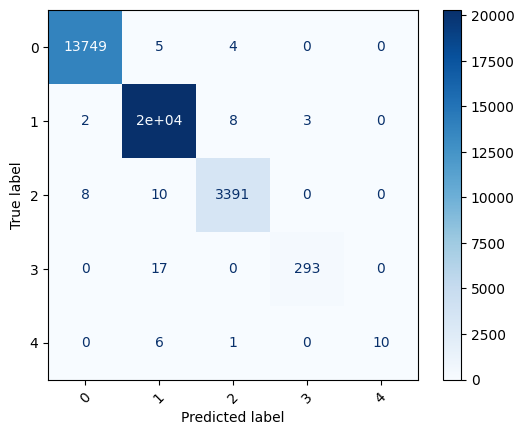

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Generate confusion matrix
cm = confusion_matrix(y_test, test_prediction)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)


*XAI-SHAP*

100%|===================| 188890/188960 [42:42<00:00]        

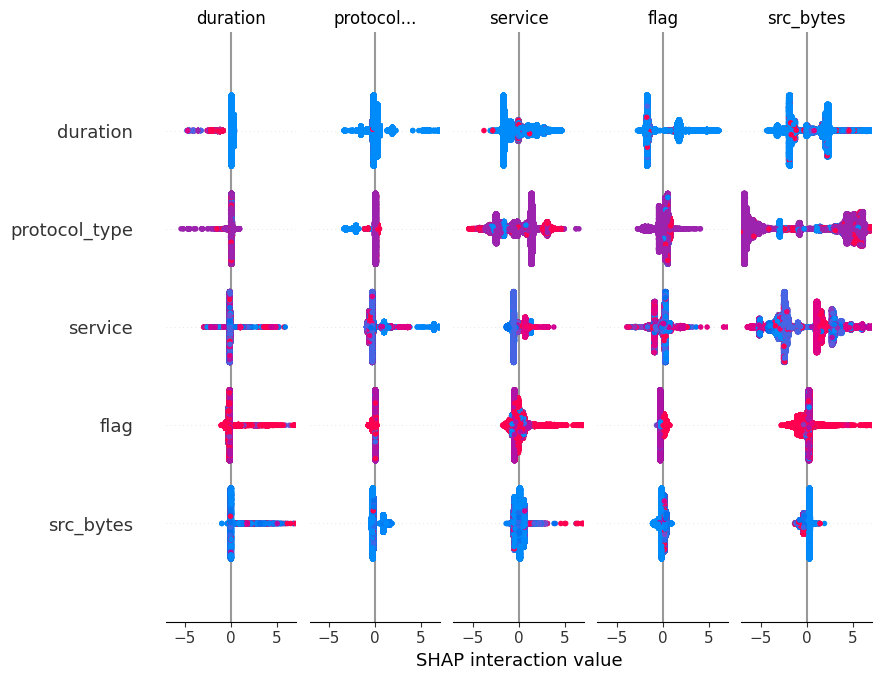

In [52]:
import shap
import numpy as np

# Ensure X_test is a NumPy array
X_test_array = np.array(X_test)

# Generate SHAP values
explainer = shap.Explainer(XGB, X_train)
shap_values = explainer(X_test_array)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test_array, feature_names=X_train.columns)

*LIME EXPLANATION*

In [53]:
import lime.lime_tabular
import numpy as np

# Convert X_train to a NumPy array
X_train_array = X_train.values
X_test_array = X_test.values

# Initialize LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_array, 
    feature_names=X_train.columns.tolist(),  # Ensure feature names are provided as a list
    class_names=[0,1], 
    discretize_continuous=True
)

# Select a random instance from X_test
idx = np.random.randint(0, X_test.shape[0])

# Explain the selected instance
exp = explainer.explain_instance(X_test_array[idx], DT.predict_proba)

# Show the explanation
exp.show_in_notebook()


e:\codebook\Machine Learning\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


*Saving Model*

In [54]:
import pickle 

In [55]:
# save the model
model = rfc  # Your machine learning model object
file_path = 'rfc-cyber.pkl'  # Path to the file where you want to save the model

with open(file_path, 'wb') as file:
    pickle.dump(model, file)

In [56]:
import pickle
# load the model

file_path = 'rfc-cyber.pkl'  # Path to the saved model file

with open(file_path, 'rb') as file:
    loaded_model = pickle.load(file)

*User's Prediction*

In [57]:
loaded_model.predict([[0,1,13,10,491,0,2,2,0.0,0.0,0.17,0.0]])

e:\codebook\Machine Learning\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

In [58]:
loaded_model.predict([[0,1,44,1,0,0,121,19,0.0,0.0,0.07,0.0]])

e:\codebook\Machine Learning\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0], dtype=int64)

In [59]:
loaded_model.predict([[0,0,6,10,18,0,1,1,0.0,0.0,1.0,0.0]])

e:\codebook\Machine Learning\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([2], dtype=int64)